# filter_avg_f4
This notebook will build two modules in which the overlay is controlled using pybind11 and CFFI respectively. The `.so` files will be copied into the `zypy/lib/` folder so they can be used with ZyPy. The generic initalisation code is found below. After that, four implementatiations will be made and compared: the default NumPy one, the hardware accelerated version using PYNQ, the hardware accelerated version using pybind11 and the hardware accelerated version using CFFI. A timing analysis at the end will reveal the minimum stream size required for the accelerators to be more beneficial than the default NumPy implementation. To build and do the analysis, click on `Kernel > Restart & Run All`.

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/filter_avg_f4.bit")

M, N = 100, 100

x1 = allocate(shape=(M, N), dtype="f4")
out = allocate(shape=(M, N), dtype="f4")

x1[:] = np.random.rand(*x1.shape) + 1
out[:] = np.zeros(out.shape)

# NumPy
This is just a wrapper around the default NumPy implementation. The wrapper is required so we can compare it in the timing analysis.

In [2]:
def filter_avg_f4_numpy(x1, out):
    out[:] = x1[:]
    out[1:-1, 1:-1] = 0.2 * (
      x1[1:-1, 1:-1] +
      x1[:-2, 1:-1] +
      x1[2:, 1:-1] +
      x1[1:-1, :-2] +
      x1[1:-1, 2:]
    )

out[:] = 0
filter_avg_f4_numpy(x1, out)
print(f"filter_avg_f4_numpy = {out}")

filter_avg_f4_numpy = [[1.296496  1.8705478 1.9647924 ... 1.8284323 1.1524236 1.6646081]
 [1.1657425 1.4420944 1.422201  ... 1.6511616 1.539968  1.3811685]
 [1.0883642 1.4271669 1.3637537 ... 1.5522726 1.5290493 1.3340511]
 ...
 [1.6907862 1.3719832 1.5519608 ... 1.4607917 1.7707318 1.4477668]
 [1.4906814 1.383455  1.5348579 ... 1.7115669 1.4110779 1.0313082]
 [1.5987314 1.378473  1.1149542 ... 1.9061413 1.003926  1.6088834]]


# PYNQ
This is the default PYNQ implementation, in which the AXI4-Lite registers are controlled using the built-in MMIO module.

In [3]:
def filter_avg_f4_pynq(x1, out):
    overlay.filter_avg_f4_0.mmio.write(0x10, (x1.shape[0] << 0) | (x1.shape[1] << 16))  # Set args
    overlay.filter_avg_f4_0.mmio.write(0x00, 0x01)  # Start the IP core

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_0.recvchannel.transfer(out)
    overlay.axi_dma_0.recvchannel.wait()

out[:] = 0
filter_avg_f4_pynq(x1, out)
print(f"filter_avg_f4_pynq = {out}")

filter_avg_f4_pynq = [[1.296496  1.8705478 1.9647924 ... 1.8284323 1.1524236 1.6646081]
 [1.1657425 1.4420944 1.4222012 ... 1.6511616 1.539968  1.3811685]
 [1.0883642 1.427167  1.3637537 ... 1.5522724 1.5290493 1.3340511]
 ...
 [1.6907862 1.3719832 1.5519608 ... 1.4607916 1.7707319 1.4477668]
 [1.4906814 1.3834552 1.534858  ... 1.7115669 1.4110779 1.0313082]
 [1.5987314 1.378473  1.1149542 ... 1.9061413 1.003926  1.6088834]]


# pybind11
This is the pybind11 implementation, in which all registers are controlled by `mmap`ing the physical memory `/dev/mem/`.

In [4]:
%%pybind11 filter_avg_f4_pybind11

#include "defines.h"

void filter_avg_f4(
    unsigned int x1_addr,
    unsigned int out_addr,
    unsigned int height,
    unsigned int width)
{
    init();
    
    filter_avg_f4_0_args_args_w(((height << 0) | (width << 16)));
    filter_avg_f4_0_ctrl_ap_start_rw(0x1);

    unsigned int length = height * width * sizeof(float); 

    axi_dma_0_mm2s_dmacr_reset_rw(0x1);
    axi_dma_0_s2mm_dmacr_reset_rw(0x1);
    
    axi_dma_0_mm2s_dmacr_rs_rw(0x1);
    axi_dma_0_mm2s_sa_source_address_rw(x1_addr);
    axi_dma_0_mm2s_length_length_rw(length);
    
    axi_dma_0_s2mm_dmacr_rs_rw(0x1);
    axi_dma_0_s2mm_da_destination_address_rw(out_addr);
    axi_dma_0_s2mm_length_length_rw(length);
    while(!(axi_dma_0_s2mm_dmasr_idle_r()));

    exit();
}

In [5]:
# This cell writes the above source code to a file, so that it can be reused for the CFFI implementation.
# Please make sure the cell above is the last cell executed!

with open(f"filter_avg_f4.c", "w") as f:
    code = ("#" + _ih[-2].split("#", 1)[1])[:-2].replace("\\n", "\n")
    f.write(code)

In [6]:
import filter_avg_f4_pybind11 as calc

def filter_avg_f4_pybind11(x1, out):
    calc.filter_avg_f4(x1.physical_address, out.physical_address, *x1.shape)

out[:] = 0
filter_avg_f4_pybind11(x1, out)
print(f"filter_avg_f4_pybind11 = {out}")

filter_avg_f4_pybind11 = [[1.296496  1.8705478 1.9647924 ... 1.8284323 1.1524236 1.6646081]
 [1.1657425 1.4420944 1.4222012 ... 1.6511616 1.539968  1.3811685]
 [1.0883642 1.427167  1.3637537 ... 1.5522724 1.5290493 1.3340511]
 ...
 [1.6907862 1.3719832 1.5519608 ... 1.4607916 1.7707319 1.4477668]
 [1.4906814 1.3834552 1.534858  ... 1.7115669 1.4110779 1.0313082]
 [1.5987314 1.378473  1.1149542 ... 1.9061413 1.003926  1.6088834]]


# CFFI
This is the CFFI implementation, of which the source code is identical to the pybind11 implementation.
The only thing that needs to be added are the C definitions.

In [7]:
%%writefile build_filter_avg_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    r"""
void filter_avg_f4(
    unsigned int x1_addr,
    unsigned int out_addr,
    unsigned int height,
    unsigned int width
);
    """
)

with open("filter_avg_f4.c") as f:
    ffibuilder.set_source("filter_avg_f4_cffi", f.read())

if __name__ == "__main__":
    ffibuilder.compile(verbose=True)

Writing build_filter_avg_f4_cffi.py


In [8]:
%%bash

/home/xilinx/perf_env/bin/python  build_filter_avg_f4_cffi.py
cp filter_avg_f4_cffi.cpython-37m-arm-linux-gnueabihf.so ../
cp filter_avg_f4_pybind11.so ../

generating ./filter_avg_f4_cffi.c
the current directory is '/home/xilinx/jupyter_notebooks/zypy/lib/filter_avg_f4'
running build_ext
building 'filter_avg_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c filter_avg_f4_cffi.c -o ./filter_avg_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./filter_avg_f4_cffi.o -o ./filter_avg_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In file included from filter_avg_f4_cffi.c:569:0:
defines.h:106:15: warning: backslash-newline at end of file
 #define exit()\
                


In [9]:
from filter_avg_f4_cffi import lib as calc

def filter_avg_f4_cffi(x1, out):
    calc.filter_avg_f4(x1.physical_address, out.physical_address, *x1.shape)

out[:] = 0
filter_avg_f4_cffi(x1, out)
print(f"filter_avg_f4_cffi = {out}")

filter_avg_f4_cffi = [[1.296496  1.8705478 1.9647924 ... 1.8284323 1.1524236 1.6646081]
 [1.1657425 1.4420944 1.4222012 ... 1.6511616 1.539968  1.3811685]
 [1.0883642 1.427167  1.3637537 ... 1.5522724 1.5290493 1.3340511]
 ...
 [1.6907862 1.3719832 1.5519608 ... 1.4607916 1.7707319 1.4477668]
 [1.4906814 1.3834552 1.534858  ... 1.7115669 1.4110779 1.0313082]
 [1.5987314 1.378473  1.1149542 ... 1.9061413 1.003926  1.6088834]]


# Timing analysis
The timing analysis is done for each of the functions that is accelerated in hardware. The values of the stream size for which the hardware implementation provides acceleration are given by `pynq_min`, `pybind11_min` and `cffi_min` respectively. Equivalently `pynq_min_reconf`, `pybind11_min_reconf` and `cffi_min_recong` indicate the size required in case reconfiguration is taken into account as well.

## filter_avg_f4


kernel = numpy, n = 16, t = 0.0022087356
kernel = pynq, n = 16, t = 0.1003055146
kernel = pybind11, n = 16, t = 0.0004202895
kernel = cffi, n = 16, t = 0.00020055470000000003
kernel = numpy, n = 32, t = 0.0021662338
kernel = pynq, n = 32, t = 0.10003477370000001
kernel = pybind11, n = 32, t = 0.00040558280000000004
kernel = cffi, n = 32, t = 0.00021090370000000002
kernel = numpy, n = 64, t = 0.0021854714
kernel = pynq, n = 64, t = 0.10081656350000001
kernel = pybind11, n = 64, t = 0.00041653390000000005
kernel = cffi, n = 64, t = 0.0002053249
kernel = numpy, n = 128, t = 0.0022296356000000004
kernel = pynq, n = 128, t = 0.10030229890000002
kernel = pybind11, n = 128, t = 0.00017569350000000002
kernel = cffi, n = 128, t = 0.0002793055
kernel = numpy, n = 256, t = 0.0023187019
kernel = pynq, n = 256, t = 0.1001951516
kernel = pybind11, n = 256, t = 0.0004111194000000001
kernel = cffi, n = 256, t = 0.00020996990000000002
kernel = numpy, n = 512, t = 0.0024130575000000003
kernel = pynq, n 

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq              ┃ pybind11           ┃ cffi              ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.000138045975     │ 0.0062690946625   │ 2.626809375e-05    │ 1.25346687500000… │
│ 32      │ 6.769480625e-05    │ 0.00312608667812… │ 1.267446250000000… │ 6.59074062500000… │
│ 64      │ 3.4147990625e-05   │ 0.00157525880468… │ 6.508342187500001… │ 3.2082015625e-06  │
│ 128     │ 1.741902812500000… │ 0.00078361171015… │ 1.372605468750000… │ 2.18207421875e-06 │
│ 256     │ 9.057429296875e-06 │ 0.00039138731093… │ 1.605935156250000… │ 8.20194921875000… │
│ 512     │ 4.713002929687501… │ 0.00019731773046… │ 8.131628906250001… │ 4.421158203125e-… │
│ 1024    │ 2.6461283203125e-… │ 9.76895696289062… │ 1.830787109375e-07 │ 2.88252148437500… │
│ 2048    │ 1.538645556640625… │ 4.88831980957031… │ 2.1452431640625e-… │ 1.18035302734375… │
│ 4096    │ 1.015571142578125… │ 2.44845278320312… │ 1.136810546875e-07 │ 8.37046142578125… │
│ 8192    │ 7.14829833984375e… │ 1.22031369873046… │ 6.409896240234375… │ 4.59081909179687… │
│ 16384   │ 5.876591247558594… │ 6.10304147338867… │ 3.686159057617188… │ 2.79951354980468… │
│ 32768   │ 4.713620819091797… │ 3.05149585571289… │ 1.625367126464844… │ 1.89464599609375… │
│ 65536   │ 4.892797286987305… │ 1.53212676086425… │ 1.351481781005859… │ 1.43116607666015… │
│ 131072  │ 4.830118148803712… │ 7.66899450683593… │ 1.290554580688476… │ 1.18803146362304… │
│ 262144  │ 5.062325336456299… │ 3.84375193786621… │ 1.121151962280273… │ 1.11133548736572… │
│ 524288  │ 4.938915174484254… │ 1.91856505393981… │ 1.072258453369140… │ 1.06738039016723… │
│ 1048576 │ 4.918278762817383… │ 9.65077211380005… │ 1.044602785110473… │ 1.04430154800415… │
│ 2097152 │ 4.902421484947205… │ 4.911826171875e-… │ 1.028314528465271… │ 1.02816239833831… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

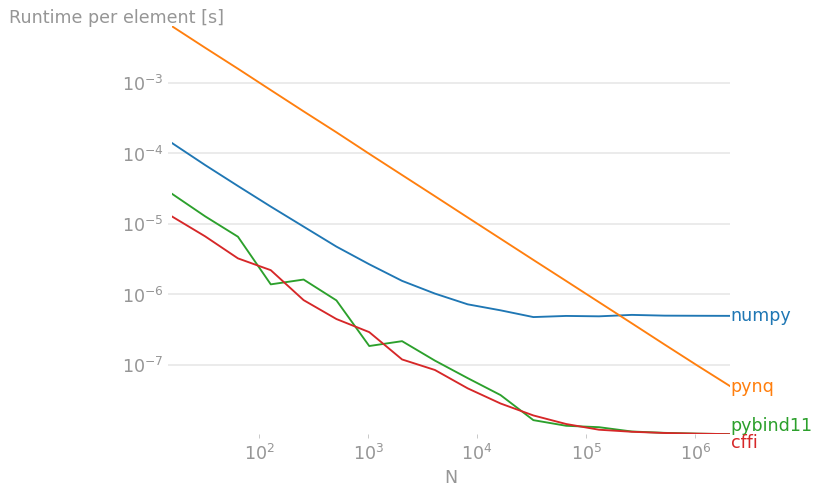

pynq_min = 131072
pybind11_min = 0
cffi_min = 0
Bitstream download time = 0.224022781


┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy              ┃ pynq - reconfig   ┃ pybind11 -         ┃ cffi - reconfig   ┃
┃         ┃                    ┃                   ┃ reconfig           ┃                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ 16      │ 0.000138045975     │ 0.020270518475    │ 0.01402769190625   │ 0.01401395848125  │
│ 32      │ 6.769480625e-05    │ 0.01012679858437… │ 0.00701338636875   │ 0.007007302646875 │
│ 64      │ 3.4147990625e-05   │ 0.00507561475781… │ 0.0035068642953125 │ 0.00350356415468… │
│ 128     │ 1.741902812500000… │ 0.00253378968671… │ 0.001751550582031… │ 0.00175236005078… │
│ 256     │ 9.057429296875e-06 │ 0.00126647629921… │ 0.0008766949234375 │ 0.00087590918320… │
│ 512     │ 4.713002929687501… │ 0.00063486222460… │ 0.000438357657031… │ 0.00043798660996… │
│ 1024    │ 2.6461283203125e-… │ 0.00031646181669… │ 0.000218955325781… │ 0.00021906049921… │
│ 2048    │ 1.538645556640625… │ 0.00015826932163… │ 0.000109600647851… │ 0.00010950415883… │
│ 4096    │ 1.015571142578125… │ 7.91775895996093… │ 5.480674282226563… │ 5.47767663818359… │
│ 8192    │ 7.14829833984375e… │ 3.95496678710937… │ 2.741062984619140… │ 2.73924390747070… │
│ 16384   │ 5.876591247558594… │ 1.97763069152832… │ 1.371012703247070… │ 1.37012605773925… │
│ 32768   │ 4.713620819091797… │ 9.88812857666015… │ 6.852886392211914… │ 6.85557918090820… │
│ 65536   │ 4.892797286987305… │ 4.95044312133789… │ 3.431831178283691… │ 3.43262802124023… │
│ 131072  │ 4.830118148803712… │ 2.47605763092041… │ 1.722063726043701… │ 1.72103849487304… │
│ 262144  │ 5.062325336456299… │ 1.23895428390502… │ 8.65790609741211e… │ 8.65692444992065… │
│ 524288  │ 4.938915174484254… │ 6.19146050453186… │ 4.380121295928955… │ 4.37963348960876… │
│ 1048576 │ 4.918278762817383… │ 3.10152493667602… │ 2.240908003807068… │ 2.24087788009643… │
│ 2097152 │ 4.902421484947205… │ 1.55940647983551… │ 1.171055315494537… │ 1.17104010248184… │
└─────────┴────────────────────┴───────────────────┴────────────────────┴───────────────────┘

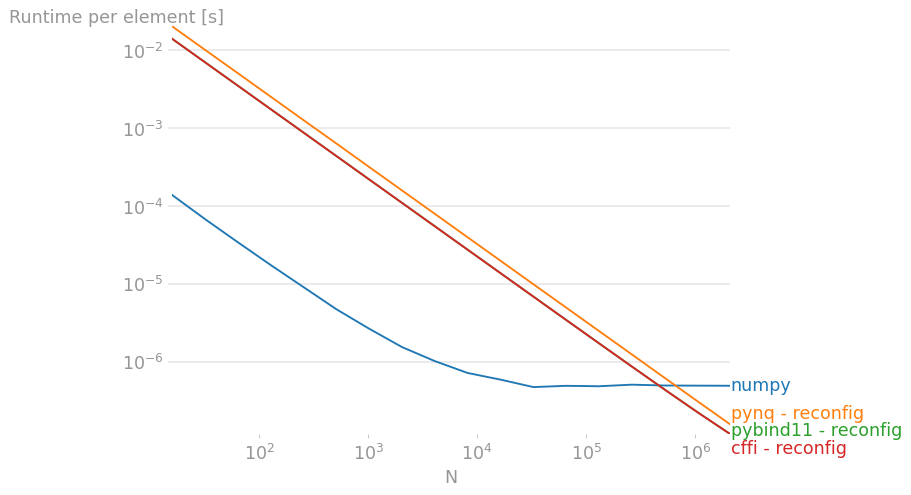

pynq_min_reconf = 524288
pybind11_min_reconf = 262144
cffi_min_reconf = 262144


In [10]:
from perfplot._main import PerfplotData
import matplotlib.pyplot as plt
import time
import os
import sys

# Import the lower-level ZyPy module
zypy_path = os.path.abspath(os.path.join("../.."))

if zypy_path not in sys.path:
    sys.path.append(zypy_path)
    
from zypy import ZyPy as zp

overlay = Overlay("/home/xilinx/jupyter_notebooks/zypy/overlays/filter_avg_f4.bit")   # Reload the overlay or PYNQ won't restart DMAs (because of bitstream download using ZyPy).

def _setup(n):

    # Adjust the setup as required. The return value(s) will be passed as arguments to the kernels.

    M = N = int(np.sqrt(n))
    x1 = allocate(shape=(M, N), dtype="f4")
    out = allocate(shape=(M, N), dtype="f4")
    
    x1[:] = np.random.rand(*x1.shape)
    out[:] = np.zeros(out.shape)

    return x1, out

iters = 10  # Specify the number of iterations per kernel per input size here.
n_range = [2 ** k for k in range(4, 22)]  # Specify the input size range here.

kernels = [filter_avg_f4_numpy, filter_avg_f4_pynq, filter_avg_f4_pybind11, filter_avg_f4_cffi]
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)
labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "N"

# Do the actual timings.
for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        print(f"kernel = {labels[j]}, n = {n}, t = {timings_s[j,i]}")

    for x in data:
        x.freebuffer()

# Print and plot the timing results.

p = PerfplotData(
    n_range,
    timings_s / n_range,
    None,
    labels,
    xlabel
)

print(p)
plt.figure(figsize=(8, 6), dpi=90)
p.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points between the NumPy version and the PYNQ, pybind11 and CFFI versions, respectively.

pynq_min = 0 if timings_s[1][0] < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[1]))).flatten()
if intersections.size > 0: pynq_min = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[2]))).flatten()
if intersections.size > 0: pybind11_min = n_range[intersections[-1]]  
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - timings_s[3]))).flatten()
if intersections.size > 0: cffi_min = n_range[intersections[-1]]
    
print(f"pynq_min = {pynq_min}")
print(f"pybind11_min = {pybind11_min}")
print(f"cffi_min = {cffi_min}")

# Find the bitstream download time.

t0_ns = time.time_ns()
zp.download_bitfile("/home/xilinx/jupyter_notebooks/zypy/overlays/filter_avg_f4.bit")
t1_ns = time.time_ns()

bitstream_dl_time = 1e-9 * (t1_ns - t0_ns)

print(f"Bitstream download time = {bitstream_dl_time}")

# Print and plot the timing results (including reconfiguration overhead).

q = PerfplotData(
    n_range,
    np.array([(timing_s + bitstream_dl_time) / n_range if i else timing_s / n_range for i, timing_s in enumerate(timings_s)]),
    None,
    np.array([label + " - reconfig" if i else label for i, label in enumerate(labels)]),
    xlabel
)

print(q)
plt.figure(figsize=(8, 6), dpi=90)
q.plot()
plt.ylabel('Runtime per element [s]')
plt.show()

# Find the intersection points taking into account the bitstream download overhead.

pynq_min_reconf, pybind11_min_reconf, cffi_min_reconf = np.inf, np.inf, np.inf

pynq_min = 0 if timings_s[1][0] + bitstream_dl_time < timings_s[0][0] else np.inf
pybind11_min = 0 if timings_s[2][0] + bitstream_dl_time < timings_s[0][0] else np.inf
cffi_min = 0 if timings_s[3][0] + bitstream_dl_time < timings_s[0][0] else np.inf

intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[1] + bitstream_dl_time)))).flatten()
if intersections.size > 0:pynq_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[2] + bitstream_dl_time)))).flatten()
if intersections.size > 0: pybind11_min_reconf = n_range[intersections[-1]]
intersections = np.argwhere(np.diff(np.sign(timings_s[0] - (timings_s[3] + bitstream_dl_time)))).flatten()
if intersections.size > 0: cffi_min_reconf = n_range[intersections[-1]]

print(f"pynq_min_reconf = {pynq_min_reconf}")
print(f"pybind11_min_reconf = {pybind11_min_reconf}")
print(f"cffi_min_reconf = {cffi_min_reconf}")